In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

from train import MCTS_HYPERPARAMETERS, load_from_checkpoint, collect_episode, train, rotate_training_examples
import torch
import numpy
from model_3d import MonteCarlo3d
from model_2d import MonteCarlo2d
from resnet import ResNet2Heads
from utils import input_to_tensor_3d, input_to_tensor
import torch.multiprocessing as mp
from train import save_checkpoint, load_from_checkpoint, ReplayMemory, MetricsHistory, test_network
import IPython.display as display
import matplotlib.pyplot as plt
import time
import importlib
import warnings

In [2]:
MODEL_TO_LOAD = "" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True
PLOT_EVERY = 25
WARMUP_AMOUNT = 48000

# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hyperparameters = MCTS_HYPERPARAMETERS() # use kwargs to specify non-default values


In [3]:
if MODEL_TO_LOAD:
    _, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, ResNet2Heads, load_replay_memory=LOAD_REPLAY_MEMORY)
    metrics_history.figs = [plt.figure() for _ in range(6)]
else:
    hyperparameters.replay_memory_size = 48000
    hyperparameters.minibatch_size = 512
    hyperparameters.weight_decay = 0.01
    hyperparameters.num_mcts_train_evals = 50
    hyperparameters.num_episodes = 100000
    hyperparameters.mcts_c_puct = 25
    hyperparameters.minibatches_per_episode = 4
    hyperparameters.lr = 5e-6
    hyperparameters.mcts_tau = 0.95
    hyperparameters.checkpoint_every = 250
    hyperparameters.c_prob = 50
    model = ResNet2Heads()
    replay_memory = ReplayMemory(hyperparameters.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.weight_decay)
    metrics_history = MetricsHistory()
    run_tag = 'mcresnet1283'     
    episode = 0
    
    
NUM_PROCS = 30

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

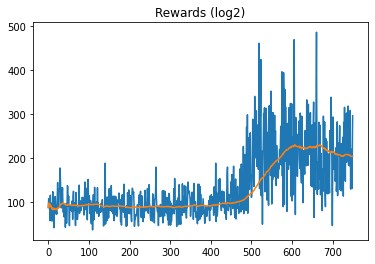

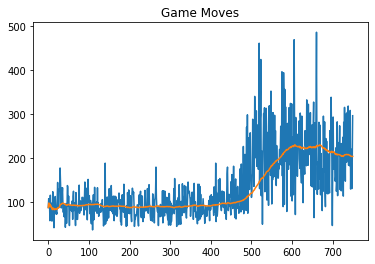

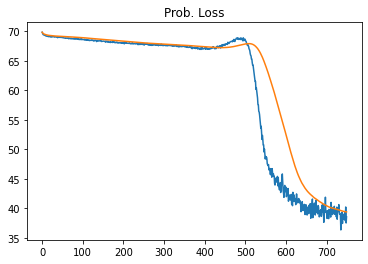

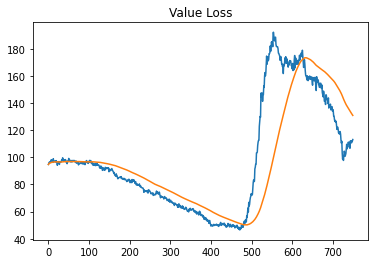

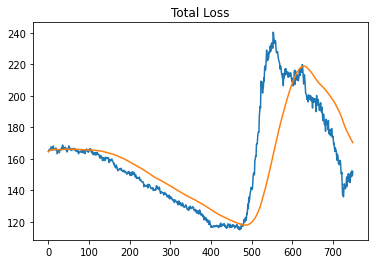

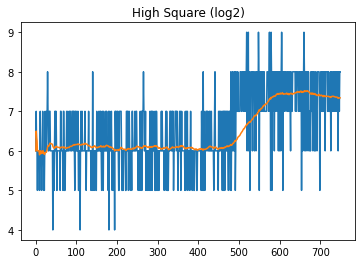

[EPISODE 750] Total Loss: 151.6512980854622, Prob Loss 38.538955250989545, Value Loss 113.11234283447266, Reward 296, Moves: 296, Highest Square: 8, PID: 549785
Saving model checkpoint...
Saved model checkpoint!
[EPISODE 751] Total Loss: 154.1162319602372, Prob Loss 39.46245197671668, Value Loss 114.65377998352051, Reward 90, Moves: 90, Highest Square: 6, PID: 549790
[EPISODE 752] Total Loss: 148.88372302255172, Prob Loss 37.610907318206024, Value Loss 111.2728157043457, Reward 183, Moves: 183, Highest Square: 7, PID: 549793
[EPISODE 753] Total Loss: 147.174406191248, Prob Loss 39.07007422103315, Value Loss 108.10433197021484, Reward 97, Moves: 97, Highest Square: 6, PID: 549801
[EPISODE 754] Total Loss: 148.22397750842532, Prob Loss 38.235112609743695, Value Loss 109.98886489868164, Reward 200, Moves: 200, Highest Square: 7, PID: 549808
[EPISODE 755] Total Loss: 149.244062126931, Prob Loss 38.783574761208314, Value Loss 110.46048736572266, Reward 290, Moves: 290, Highest Square: 8, PI

Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-6:
Process ForkPoolWorker-9:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-27:
Process ForkPoolWorker-8:
Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-30:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-28:
Process ForkPoolWorker-4:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-24:
Process ForkPoolWorker-7:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/

[EPISODE 767] Total Loss: 144.78848921163643, Prob Loss 38.55214964254465, Value Loss 106.2363395690918, Reward 316, Moves: 316, Highest Square: 8, PID: 549781


In [ ]:
def enque_and_train(results):
    torch.set_num_threads(15)
    
    training_examples, reward, moves, high_square, pid = results
    training_examples = rotate_training_examples(training_examples)
    replay_memory.extend(training_examples)
    
    if replay_memory.size() >= WARMUP_AMOUNT:
        cum_vl, cum_pl, cum_tl = 0.0, 0.0, 0.0
        for i in range(hyperparameters.minibatches_per_episode):
            value_loss, prob_loss, total_loss = train(replay_memory.sample(hyperparameters.minibatch_size), model, optimizer, tensor_conversion_fn=input_to_tensor, c_prob=hyperparameters.c_prob)
            cum_vl += value_loss
            cum_pl += prob_loss
            cum_tl += total_loss
        cum_vl /= hyperparameters.minibatches_per_episode
        cum_pl /= hyperparameters.minibatches_per_episode
        cum_tl /= hyperparameters.minibatches_per_episode
        new_best = metrics_history.add_history({
            'reward': reward,
            'game_moves': moves,
            'prob_loss': cum_pl,
            'value_loss': cum_vl,
            'total_loss': cum_tl,
            'high_square': high_square
        })
        if metrics_history.episodes % PLOT_EVERY == 0:
            metrics_history.plot_history(window_size=100)
        
        if new_best:
            print(f'*** NEW BEST REWARD: {metrics_history.best_result} ***')
        
        print(f'[EPISODE {metrics_history.episodes}] Total Loss: {cum_tl}, Prob Loss {cum_pl}, Value Loss {cum_vl}, Reward {reward}, Moves: {moves}, Highest Square: {high_square}, PID: {pid}')
        if metrics_history.episodes % hyperparameters.checkpoint_every == 0:
            print('Saving model checkpoint...')
            save_checkpoint(metrics_history.episodes, model, optimizer, hyperparameters, metrics_history, replay_memory, run_tag=run_tag, save_replay_memory=True)
            print('Saved model checkpoint!')
    else:
        print(f'Replay memory size not large enough, {replay_memory.size()} < {WARMUP_AMOUNT}')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    with mp.Pool(NUM_PROCS) as p:
        results = []
        for n in range(metrics_history.episodes, hyperparameters.num_episodes):
            results.append(p.apply_async(collect_episode, (model, hyperparameters, input_to_tensor, ), callback=enque_and_train, error_callback=print))
        for r in results:
            r.wait()

In [ ]:
hyperparameters.num_mcts_test_evals = 500
test_network(model, hyperparameters, input_to_tensor, debug_print=True)